In [1]:
import os
import sys
import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

In [2]:
def fn_plot_torch_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')

    plt.tight_layout()


In [3]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())

    fig, ax = plt.subplots(figsize = (6,6))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [4]:
print(fn_plot_torch_hist.__doc__)  ##used to access comments from a python file

None


In [5]:
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE)

inpDir = 'C:/Users/Administrator.DAI-PC2/Documents/DNN/day 9'
outDir = '../output'
modelDir = '../models'
subDir = 'ionosphere'

EPOCHS = 500 # number of epochs

ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
BATCH_SIZE=16
WEIGHT_DECAY = 0.001
TRAIN_SIZE = int(17*BATCH_SIZE) #complete batches

PATIENCE = 30
LR_FACTOR =0.1
LR_PATIENCE = 10
input_shape = 34
# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.brg
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [6]:
#trainFilepath = os.path.join(inpDir,subDir,'ionosphere.data')
data_df = pd.read_csv('ionosphere.data',header=None)
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [7]:
train_df,test_df=train_test_split(data_df,
                                  train_size=TRAIN_SIZE,
                                  random_state = RANDOM_STATE,
                                  stratify=data_df[data_df.columns[-1]])
train_df.shape,test_df.shape

((272, 35), (79, 35))

In [8]:
#Using singleton design pattern
#has one standard scaler and one label encoder
class Transformers:
     _instance= None

     def __init__(self):
      if Transformers._instance is not None:
        raise Exception ('GlobalScaler class is a singleton.')

      self.scaler= StandardScaler()
      self.encoder = LabelEncoder()

     @classmethod
     def get_instance(cls):
      if cls._instance is None:
        cls._instance= Transformers()
      return cls._instance

In [9]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
#implement dataset class
class IonoDS(Dataset):

  transformers = Transformers.get_instance() #Scaler and encoder

  def __init__(self,
               dataframe:pd.DataFrame,
               device:str= device,
               is_train  = True,
               label_col = None
               ):

    super(IonoDS, self).__init__()

    self.df=dataframe
    self.device=device
    self.is_train = is_train
    self.label_col = label_col
    self.scaler = self.transformers.scaler
    self.encoder = self.transformers.encoder

    y= self.df[self.label_col].to_numpy()
    X = self.df.drop(self.label_col,axis=1).to_numpy()

    if self.is_train:
      self.labels = self.encoder.fit_transform(y)
      self.features = self.scaler.fit_transform(X)
    else:
      self.labels = self.encoder.transform(y)
      self.features = self.scaler.transform(X)


  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    #Extract features and label from dataframe row
    features=self.features[index]
    label=self.labels[index]

    #convert to Pytorch tensors
    features=torch.tensor(features,
                          dtype=torch.float32,
                          device=self.device)

    label=torch.tensor(label,
                       dtype=torch.int64,
                       device=self.device)

    return features,label


In [11]:
class Model(nn.Module):
  def __init__(self,input_dim):
    super(Model, self).__init__()

    #define the dropout rates
    self.dor1 = 0.05
    self.dor2 = 0.1
    self.dor3 = 0.15

    #Layer 1
    self.layer1= nn.Linear(input_dim,26)  #34 * 26
    self.bn1 = nn.BatchNorm1d(26)
    self.activ1=nn.ReLU()
    self.dropout1 = nn.Dropout(self.dor1)

    #Layer 2
    self.layer2=nn.Linear(26,18)  ##26 * 18
    self.bn2 = nn.BatchNorm1d(18)
    self.activ2=nn.ReLU()
    self.dropout2 = nn.Dropout(self.dor2)

#Layer 3
    self.layer3=nn.Linear(18,10)  #18 * 108
    self.bn3 = nn.BatchNorm1d(10)
    self.activ3=nn.ReLU()
    self.dropout3 = nn.Dropout(self.dor3)

    #Layer 4
    self.layer4 = nn.Linear(10,2)  #10 * 2
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self,x):

    #x = self.dropout1(self.activ1(self.bn1(self.layer1(x))))
       #OR
    x=self.layer1(x)
    x=self.bn1(x)
    x=self.activ1(x)
    x = self.dropout1(x)

    x=self.layer2(x)
    x=self.bn2(x)
    x=self.activ2(x)
    x = self.dropout2(x)

    x=self.layer3(x)
    x=self.bn3(x)
    x=self.activ3(x)
    x = self.dropout3(x)

    x=self.layer4(x)
    return self.softmax(x)

model = Model(input_dim=input_shape).to(device)
print(model)

Model(
  (layer1): Linear(in_features=34, out_features=26, bias=True)
  (bn1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ1): ReLU()
  (dropout1): Dropout(p=0.05, inplace=False)
  (layer2): Linear(in_features=26, out_features=18, bias=True)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ2): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (layer3): Linear(in_features=18, out_features=10, bias=True)
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ3): ReLU()
  (dropout3): Dropout(p=0.15, inplace=False)
  (layer4): Linear(in_features=10, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [12]:
label_col = 34
train_ds=IonoDS(train_df,is_train=True,label_col=label_col)
test_ds=IonoDS(test_df,is_train=False,label_col=label_col)

In [13]:
feat , lbl = next(iter(train_ds))
feat.shape, lbl

(torch.Size([34]), tensor(1))

In [14]:
train_loader=DataLoader(train_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

test_loader=DataLoader(test_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

In [15]:
feats , lbls = next(iter(train_loader))
feats.shape, lbls

(torch.Size([16, 34]),
 tensor([1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1]))

In [16]:
model(feats)

tensor([[-0.2827, -1.4014],
        [-0.6009, -0.7948],
        [-0.8768, -0.5381],
        [-1.0712, -0.4195],
        [-0.9818, -0.4694],
        [-0.4170, -1.0759],
        [-0.3460, -1.2293],
        [-0.7744, -0.6180],
        [-0.5454, -0.8666],
        [-0.7634, -0.6275],
        [-1.0150, -0.4500],
        [-0.5283, -0.8906],
        [-0.7954, -0.6004],
        [-0.7808, -0.6126],
        [-0.7439, -0.6448],
        [-1.4624, -0.2635]], grad_fn=<LogSoftmaxBackward0>)

In [18]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(model.parameters(),
                             lr=ALPHA,
                             weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=LR_FACTOR,
                                                       patience=LR_PATIENCE,
                                                       min_lr = 0.00001)

minLoss = float('inf') #minimum loss
#savePath = os.path.join(modelDir, subDir, 'iono.pth')
savePath='iono.pth'
# Train the model for multiple epochs

for epoch in range(EPOCHS):

    # Training loop
    train_loss = 0.0
    train_acc = 0.0


    for i, data in enumerate(train_loader):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)

        preds = torch.argmax(outputs, dim = 1)

        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

        batch_loss.backward()

        optimizer.step()

        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)

    train_loss /= len(train_ds)
    train_acc /= len(train_ds)

    loss.append(train_loss)
    acc.append(train_acc)

    # Testing loop
    test_loss = 0.0
    test_acc = 0.0


    with torch.no_grad():
        model.eval()
        for data in test_loader:

            inputs, labels = data

            outputs = model(inputs)

            preds = torch.argmax(outputs, dim = 1)

            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)

        test_loss /= len(test_ds)
        test_acc /= len(test_ds)

        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)

    scheduler.step(test_loss)

    ##Add early stopping
    if test_loss < minLoss:
      minLoss = test_loss
      counter = 0
       #Save the model
      torch.save({'epoch': epoch+1,
                 'model_state_dict': model.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                  'loss':loss_fn},savePath)
    else:
      counter += 1

    if counter > PATIENCE:
      break


    print(f'At epoch {epoch:3d}', end = '')
    print(f'| Loss:{train_loss:.4f}/{test_loss:.4f}', end='')
    print(f'| Acc:{train_acc:.4f}/{test_acc:.4f}', end='')
    print(f'| LR: {scheduler.get_last_lr()[0]:.5f}', end='')
    print(f'| Counter: {counter}')

At epoch   0| Loss:0.6641/0.6004| Acc:0.6287/0.7595| LR: 0.00100| Counter: 0
At epoch   1| Loss:0.5838/0.5089| Acc:0.7500/0.8101| LR: 0.00100| Counter: 0
At epoch   2| Loss:0.4859/0.4097| Acc:0.8529/0.8861| LR: 0.00100| Counter: 0
At epoch   3| Loss:0.3823/0.3256| Acc:0.8971/0.8987| LR: 0.00100| Counter: 0
At epoch   4| Loss:0.2996/0.2591| Acc:0.9191/0.8987| LR: 0.00100| Counter: 0
At epoch   5| Loss:0.2398/0.2126| Acc:0.9301/0.9114| LR: 0.00100| Counter: 0
At epoch   6| Loss:0.2003/0.1838| Acc:0.9375/0.9241| LR: 0.00100| Counter: 0
At epoch   7| Loss:0.1730/0.1650| Acc:0.9485/0.9494| LR: 0.00100| Counter: 0
At epoch   8| Loss:0.1461/0.1558| Acc:0.9559/0.9494| LR: 0.00100| Counter: 0
At epoch   9| Loss:0.1268/0.1291| Acc:0.9596/0.9494| LR: 0.00100| Counter: 0
At epoch  10| Loss:0.1103/0.1176| Acc:0.9706/0.9620| LR: 0.00100| Counter: 0
At epoch  11| Loss:0.0968/0.1145| Acc:0.9669/0.9620| LR: 0.00100| Counter: 0
At epoch  12| Loss:0.0860/0.1081| Acc:0.9816/0.9620| LR: 0.00100| Counter: 0

In [19]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.664070,0.600405,0.628676,0.759494
1,1,0.583792,0.508933,0.750000,0.810127
2,2,0.485863,0.409683,0.852941,0.886076
3,3,0.382277,0.325616,0.897059,0.898734
4,4,0.299553,0.259140,0.919118,0.898734


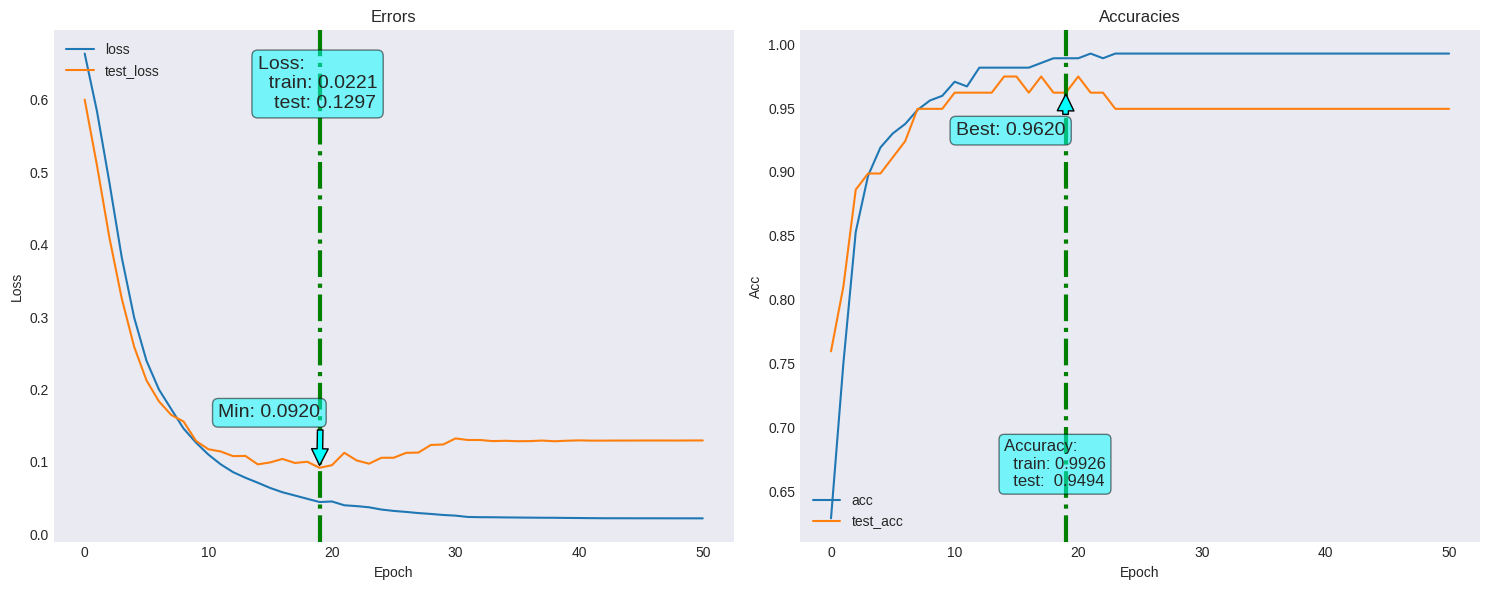

In [20]:
fn_plot_torch_hist(loss_df)

In [21]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):

    inputs, labels = data

    outputs = model(inputs)

    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [22]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        98
           1       0.99      1.00      0.99       174

    accuracy                           0.99       272
   macro avg       0.99      0.99      0.99       272
weighted avg       0.99      0.99      0.99       272



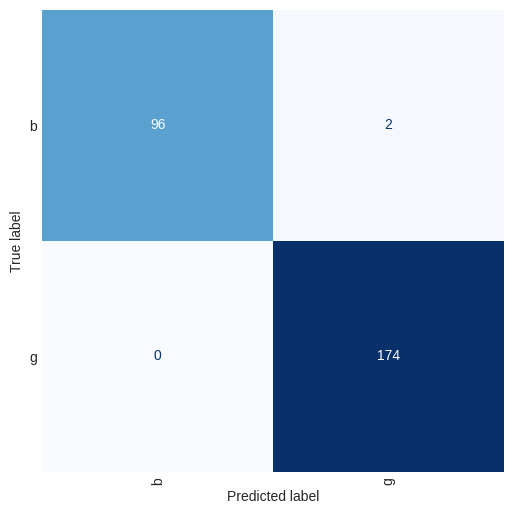

In [23]:
class_labels  = {k:v for k, v in enumerate(train_ds.transformers.encoder.classes_) }
fn_plot_confusion_matrix(y_train, y_pred, class_labels)

In [25]:
y_test = []
y_pred = []
for i, data in enumerate(test_loader):

    inputs, labels = data

    outputs = model(inputs)

    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [26]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93        28
           1       0.94      0.98      0.96        51

    accuracy                           0.95        79
   macro avg       0.95      0.94      0.94        79
weighted avg       0.95      0.95      0.95        79



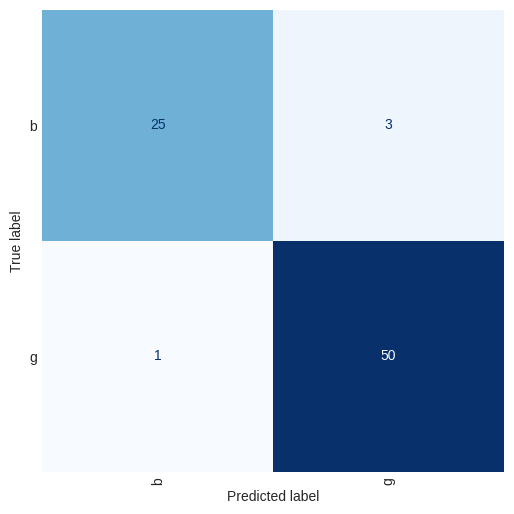

In [27]:
class_labels  = {k:v for k, v in enumerate(test_ds.transformers.encoder.classes_) }
fn_plot_confusion_matrix(y_test, y_pred, class_labels)